## Impementation
The implementation of the 5-point formula of the Poisson equation  with Dirichlet conditions consistes of

1. Define the source function $f$, and the boundary conditions $g_s$, $g_v$, $g_n$, $g_o$.
2. Choose $M$, and make the grid 
3. Construct the $A$-matrix.
4. Construct the $b$-vector. 
5. Solve the system $A U=b$. 
6. Present the solution (plot).

#### Test problem

Use as exact solution

$$ u(x,y) = x^3 + 2y^2,$$

resulting in the equation

$$ u_{xx} + u_{yy} = 6x+4 \qquad 0\leq x,y \leq 1 $$

with boundary conditions given by the exact solution. In this case, the numerical solution will give the exact solution in the grid points (why?), making it suitable to check that the implementation is correct.
 


In [12]:
%matplotlib inline
import numpy as np             
from scipy.linalg import solve    
import scipy.sparse as sparse             # Sparse matrices
from scipy.sparse.linalg import spsolve   # Linear solver for sparse matrices
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)
from mpl_toolkits.mplot3d import Axes3D     # For 3-d plot
from matplotlib import cm

In [13]:
# Boundary conditions and source functions.
def gs(x):                  # y=0
    return x**3
def gn(x):                  # y=1
    return 2+x**3
def gw(y):                  # x=0
    return 2*y**2
def ge(y):                  # x=1
    return 1+2*y**2         
def f(x,y):
    return 6*x+4

N = 4  # Number of intervals

# Lag gitteret
x = np.linspace(0, 1, N+1)
y = np.linspace(0, 1, N+1) 
h = 1/N

# Inner points
xi = x[1:-1]       
yi = y[1:-1] 
Xi, Yi = np.meshgrid(xi, yi)
Ni = N-1       # Number of inner points in each direction
Ni2 = Ni**2    # Number of inner points in total

# Construct a sparse A-matrix
B = sparse.diags([1,-4,1],[-1,0,1],shape=(Ni, Ni), format="lil")
A = sparse.kron(sparse.eye(Ni), B)
C = sparse.diags([1,1],[-Ni,Ni],shape=(Ni2, Ni2), format="lil")
A = (A+C).tocsr() # Konverter til csr-format (nødvendig for spsolve)

# Construct the right hand side
b = np.zeros(Ni2)
# Include the boundary conditions
b[0:Ni] = b[0:Ni]-gs(xi)                         # y=0
b[Ni2-Ni:Ni2] = b[Ni2-Ni:Ni2] - gn(xi)           # y=1
b[0:Ni2:Ni] = b[0:Ni2:Ni] - gw(yi)               # x=0
b[Ni-1:Ni2:Ni] = b[Ni-1:Ni2:Ni] - ge(yi)         # x=1
# Include the source funtions
b = b+h**2*f(Xi,Yi).flatten()

# Solve the system.  
Ui = spsolve(A, b)      

# Make an array to store the solution 
U = np.zeros((N+1, N+1))

# Reshape the Ui-vector to an array, and insert into Ui.
U[1:-1,1:-1] =np.reshape(Ui, (Ni,Ni)) 

# Include the boundary conditions
U[0,:] = gs(x)
U[N,:] = gn(x)
U[:,0] = gw(y)
U[:,N] = ge(y)

In [14]:
# For inspection: Print A and b
print('A =\n ', A.toarray())           # A konverteres til en full matrise først
print('\nb=\n', b)

A =
  [[-4.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  1. -4.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0. -4.  1.  0.  1.  0.  0.]
 [ 0.  1.  0.  1. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  1. -4.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0. -4.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -4.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  1. -4.]]

b=
 [ 0.203125  0.3125   -1.015625 -0.15625   0.4375   -0.96875  -2.796875
 -1.6875   -4.015625]


In [15]:
# Print out the numerical solution and the error
X, Y = np.meshgrid(x,y)
U_exact = X**3+2*Y**2
print('\nU=\n', U)
print('The error is {:.2e}'.format(np.max(np.max(abs(U-U_exact)))))


U=
 [[0.       0.015625 0.125    0.421875 1.      ]
 [0.125    0.140625 0.25     0.546875 1.125   ]
 [0.5      0.515625 0.625    0.921875 1.5     ]
 [1.125    1.140625 1.25     1.546875 2.125   ]
 [2.       2.015625 2.125    2.421875 3.      ]]
The error is 2.22e-16


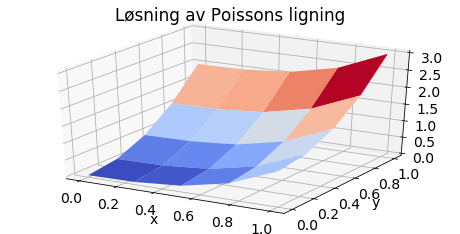

In [16]:
# Plot the solution
fig = plt.figure()
X, Y = np.meshgrid(x,y)
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, U, cmap=cm.coolwarm)            # Surface-plot
#ax.plot_wireframe(X, Y, U)         # Mesh-plot
plt.xlabel('x')
plt.ylabel('y')
plt.title('Løsning av Poissons ligning');

## The advantage of using sparse matrices

Demonstrate this with the following example: 

Choose $N=100$ (less if you have a slow computer and not much memory).

Run the code below. A full matrix is constructed from the sparse. 
The linear system is then solved by a full and a sparse solver, and the memory and cpu-time used measured for both. 

In [19]:
import time,sys
# Fullt system
Af = A.toarray()            # Construct the full matrix
print('Memory use of the full   matrix: {:d}'.format(Af.data.nbytes))
print('Memory use of the sparse matrix: {:d}'.format(A.data.nbytes))
print('Factor: {:.2e}'.format(A.data.nbytes/Af.data.nbytes))

Memory use of the full   matrix: 648
Memory use of the sparse matrix: 504
Factor: 7.78e-01


In [20]:
start = time.time()
U = solve(Af, b)            # Solve the system with a full solver
ferdig = time.time()
print('Time used for a full solver:', ferdig-start)

Time used for a full solver: 0.0007481575012207031


In [21]:
# Glissent system
start = time.time()
U = spsolve(A, b)            # Solve the system with a sparse solver
ferdig = time.time()
print('Time used for a sparse solver:', ferdig-start)

Time used for a sparse solver: 0.0004379749298095703
